In [1]:
# ========================================================================================== #
#                                          FOLPS                                             #
# ========================================================================================== #
#          Efficient computation of the redshift-space power spectrum & bispectrum in        #
#            models with massive neutrinos and certain modified gravity frameworks           #
# ========================================================================================== #

In [2]:
import os
import scipy
from scipy import special

class BackendManager:
    def __init__(self, preferred_backend='numpy'):
        """Initializes the backend according to the user's preference."""
        #self.using_jax = False
        self.backend = None
        self.modules = {}  # Stores modules for dynamic usage
        self.setup_backend(preferred_backend)

    def setup_backend(self, preferred_backend='numpy'):
        """Configures the backend dynamically between NumPy and JAX."""
        if preferred_backend == 'jax':
            try:
                import jax
                if any(device.device_kind == "Gpu" for device in jax.devices()):
                    print("✅ GPU detected. Using JAX with GPU.")
                else:
                    print("⚠️ No GPU found. Using JAX with CPU.")

                from jax import numpy as np
                from tools_jax import interp, simpson, legendre, extrapolate, extrapolate_pklin, get_pknow ##add get_linear_ir
                self.modules = {
                    "np": np,
                    "interp": interp,
                    "simpson": simpson,
                    "legendre": legendre,
                    "extrapolate": extrapolate,
                    "extrapolate_pklin": extrapolate_pklin,
                    "get_pknow": get_pknow,
                }
                #self.using_jax = True
                self.backend = 'jax'
            except (RuntimeError, ImportError) as e:
                print(f"❌ Error initializing JAX: {e}")
                print("⏳ Falling back to NumPy...")
                self.setup_backend('numpy')
        elif preferred_backend == 'numpy':
            print("✅ Using NumPy with CPU.")
            import numpy as np
            from tools import interp, simpson, legendre, extrapolate, extrapolate_pklin, get_pknow, get_linear_ir
            self.modules = {
                "np": np,
                "interp": interp,
                "simpson": simpson,
                "legendre": legendre,
                "extrapolate": extrapolate,
                "extrapolate_pklin": extrapolate_pklin,
                "get_pknow": get_pknow,
                "get_linear_ir":get_linear_ir,
            }
            #self.using_jax = False
            self.backend = 'numpy'
        else:
            raise ValueError("⚠️ Invalid backend specified. Choose 'jax' or 'numpy'.")

    def get_module(self, name):
        """Retrieves a module or function from the current backend."""
        return self.modules.get(name, None)


# Initialize with JAX if available
backend_manager = BackendManager(preferred_backend='numpy')

# Access functions and modules
np = backend_manager.get_module("np")
interp = backend_manager.get_module("interp")
simpson = backend_manager.get_module("simpson")
legendre = backend_manager.get_module("legendre")
extrapolate = backend_manager.get_module("extrapolate")
extrapolate_pklin = backend_manager.get_module("extrapolate_pklin")
get_pknow = backend_manager.get_module("get_pknow")
get_linear_ir = backend_manager.get_module("get_linear_ir")
backend = backend_manager.backend
#using_jax = backend_manager.using_jax

✅ Using NumPy with CPU.


In [3]:
def get_fnu(h, ombh2, omch2, omnuh2):
    """
    Gives some inputs for the function 'f_over_f0_EH'.

    Args:
        h = H0/100.
        ombh2: Omega_b h² (baryons)
        omch2: Omega_c h² (CDM)
        omnuh2: Omega_nu h² (massive neutrinos)
    Returns:
        h: H0/100.
        OmM0: Omega_b + Omega_c + Omega_nu (dimensionless matter density parameter)
        fnu: Omega_nu/OmM0
        mnu: Total neutrino mass [eV]
    """
    Omb = ombh2 / h**2
    Omc = omch2 / h**2
    Omnu = omnuh2 / h**2

    OmM0 = Omb + Omc + Omnu
    fnu = Omnu / OmM0
    mnu = Omnu * 93.14 * h**2

    return(h, OmM0, fnu, mnu)

In [4]:
def f_over_f0_EH(zev, k, OmM0, h, fnu, Nnu=3, Neff=3.046):
    """
    Routine to get f(k)/f0 and f0.
    f(k)/f0 is obtained following H&E (1998), arXiv:astro-ph/9710216
    f0 is obtained by solving directly the differential equation for the linear growth at large scales.

    Args:
        zev: redshift
        k: wave-number
        OmM0: Omega_b + Omega_c + Omega_nu (dimensionless matter density parameter)
        h = H0/100
        fnu: Omega_nu/OmM0
        Nnu: number of massive neutrinos
        Neff: effective number of neutrinos
    Returns:
        f(k)/f0 (when 'EdSkernels = True' f(k)/f0 = 1)
        f0
    """
    #def interp(k, x, y):  # out-of-range below
    #    from scipy.interpolate import CubicSpline
    #    return CubicSpline(x, y)(k)
    
    eta = np.log(1 / (1 + zev))   #log of scale factor
    omrv = 2.469*10**(-5)/(h**2 * (1 + 7/8*(4/11)**(4/3)*Neff)) #rad: including neutrinos
    aeq = omrv/OmM0           #matter-radiation equality

    pcb = 5./4 - np.sqrt(1 + 24*(1 - fnu))/4     #neutrino supression
    c = 0.7
    theta272 = (1.00)**2                         # T_{CMB} = 2.7*(theta272)
    pf = (k * theta272)/(OmM0 * h**2)
    DEdS = np.exp(eta)/aeq                      #growth function: EdS cosmology

    fnunonzero = np.where(fnu != 0., fnu, 1.)
    yFS = 17.2*fnu*(1 + 0.488*fnunonzero**(-7/6))*(pf*Nnu/fnunonzero)**2  #yFreeStreaming
    # pcb = 0. and yFS = 0. when fnu = 0.
    rf = DEdS/(1 + yFS)
    fFit = 1 - pcb/(1 + (rf)**c)                #f(k)/f0

    #Getting f0
    def OmM(eta):
        return 1./(1. + ((1-OmM0)/OmM0)*np.exp(3*eta) )

    def f1(eta):
        return 2. - 3./2. * OmM(eta)

    def f2(eta):
        return 3./2. * OmM(eta)

    etaini = -6  #initial eta, early enough to evolve as EdS (D + \propto a)
    zfin = -0.99

    def etaofz(z):
        return np.log(1/(1 + z))

    etafin = etaofz(zfin)
    
    from scipy.integrate import odeint
    #if using_jax:
    if backend == 'jax':
        from jax.experimental.ode import odeint

    # differential eq.
    def Deqs(Df, eta):
        Df, Dprime = Df
        return [Dprime, f2(eta)*Df - f1(eta)*Dprime]

    #eta range and initial conditions
    eta = np.linspace(etaini, etafin, 1001)   
    Df0 = np.exp(etaini)
    Df_p0 = np.exp(etaini)
        
    #solution
    Dplus, Dplusp = odeint(Deqs, [Df0,Df_p0], eta).T
    
    Dplusp_ = interp(etaofz(zev), eta, Dplusp)
    Dplus_ = interp(etaofz(zev), eta, Dplus)
    f0 = Dplusp_/Dplus_ 

    return (k, fFit, f0)

In [5]:
def get_cm(kmin, kmax, N, b_nu, inputpkT):
    """
    Coefficients c_m, see eq.~ 4.2 - 4.5 at arXiv:2208.02791

    Args:
        kmin, kmax: minimal and maximal range of the wave-number k.
        N: number of sampling points (we recommend using N=128).
        b_nu: FFTLog bias (use b_nu = -0.1. Not yet tested for other values).
        inputpkT: k-coordinates and linear power spectrum.
    Returns:
        coefficients c_m (cosmological dependent terms).
    """
    #def interp(k, x, y):  # out-of-range below
    #    from scipy.interpolate import CubicSpline
    #    return CubicSpline(x, y)(k)
    
    #define de zero matrices
    M = int(N/2)
    k, pk = inputpkT
    ii = np.arange(N)

    #"kbins" trought "delta" gives logspaced k's in [kmin, kmax]
    kbins = kmin * np.exp(ii * np.log(kmax / kmin) / (N - 1))
    f_kl = interp(kbins, k, pk) * (kbins / kmin)**(-b_nu)

    #F_m is the Discrete Fourier Transform (DFT) of f_kl
    #"forward" has the direct transforms scaled by 1/N (numpy version >= 1.20.0)
    F_m = np.fft.fft(f_kl, n=N) / N

    #etaT = bias_nu + i*eta_m
    #to get c_m: 1) reality condition, 2) W_m factor
    ii = np.arange(N + 1)
    etaT = b_nu + (2*np.pi*1j/np.log(kmax/kmin)) * (ii - N/2) * (N-1) / N
    c_m = kmin**(-(etaT))*F_m[ii - M]
    c_m = np.concatenate([c_m[:1] / 2., c_m[1:-1], c_m[-1:] / 2.])

    return c_m

In [6]:
class MatrixCalculator:
    """
    A class to compute M matrices that are independent of cosmological parameters, calculated only once per instance.

    Args:
        nfftlog (int, optional): Number of sample points for FFTLog integration. Defaults to 128 if not specified.
                                 It is recommended to use this default setting; see Figure 8 in arXiv:2208.02791 for details.
        kmin (float, optional): Minimum value of the k-range for the calculations. Defaults to 1e-7.
        kmax (float, optional): Maximum value of the k-range for the calculations. Defaults to 100.0.
        b_nu (float): Bias parameter for FFTLog. It is recommended to use the default value for accurate results.
        A_full (bool, optional): Determines whether to compute the full A_TNS function. If set to True (default), the 
                                 function considers contributions from b1, b2, and bs2. If False, it uses an approximation 
                                 based on only the linear bias (b1).

    Returns:
        list: A list containing all computed M matrices.
    """
    def __init__(self, nfftlog=128, kmin=10**(-7), kmax=100., b_nu=-0.1, A_full=True):
        global A_full_status
        self.nfftlog = nfftlog
        self.kmin = kmin
        self.kmax = kmax
        self.b_nu = b_nu  # not yet tested for other values
        self.A_full = A_full
        A_full_status = A_full
        self.filename = f'matrices_nfftlog{self.nfftlog}_Afull{A_full_status}.npy'
        
    def Imatrix(self, nu1, nu2):
        return 1 / (8 * np.pi**(3 / 2.)) * (special.gamma(3 / 2. - nu1) * special.gamma(3 / 2. - nu2) * special.gamma(nu1 + nu2 - 3 / 2.))\
                / (special.gamma(nu1) * special.gamma(nu2) * special.gamma(3 - nu1 - nu2))
    
    #M22-type
    def M22(self, nu1, nu2):
            
        #Overdensity and velocity
        def M22_dd(nu1, nu2):
            return self.Imatrix(nu1,nu2)*(3/2-nu1-nu2)*(1/2-nu1-nu2)*( (nu1*nu2)*(98*(nu1+nu2)**2 - 14*(nu1+nu2) + 36) - 91*(nu1+nu2)**2+ 3*(nu1+nu2) + 58)/(196*nu1*(1+nu1)*(1/2-nu1)*nu2*(1+nu2)*(1/2-nu2))
            
        def M22_dt_fp(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-1+2*(nu1+nu2))*(-23-21*nu1+(-38+7*nu1*(-1+7*nu1))*nu2+7*(3+7*nu1)*nu2**2) )/(196*nu1*(1+nu1)*nu2*(1+nu2)*(-1+2*nu2))
        
        def M22_tt_fpfp(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-12*(1-2*nu2)**2 + 98*nu1**(3)*nu2 + 7*nu1**2*(1+2*nu2*(-8+7*nu2))- nu1*(53+2*nu2*(17+7*nu2))))/(98*nu1*(1+nu1)*nu2*(1+nu2)*(-1+2*nu2))
            
        def M22_tt_fkmpfp(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-37+7*nu1**(2)*(3+7*nu2) + nu2*(-10+21*nu2) + nu1*(-10+7*nu2*(-1+7*nu2))))/(98*nu1*(1+nu1)*nu2*(1+nu2))
        
        #A function
        def MtAfp_11(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-1+2*(nu1+nu2))*(-5+nu1*(-4+7*(nu1+nu2))))/(7*nu1*(1+nu1)*(-1+2*nu1)*nu2)
        
        def MtAfkmpfp_12(nu1, nu2):
            return -self.Imatrix(nu1,nu2)*(((-3+2*(nu1+nu2))*(-1+2*(nu1+nu2))*(6+7*(nu1+nu2)))/(56*nu1*(1+nu1)*nu2*(1+nu2)))
        
        def MtAfkmpfp_22(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-18+3*nu1*(1+4*(10-9*nu1)*nu1)+75*nu2+8*nu1*(41+2*nu1*(-28+nu1*(-4+7*nu1)))*nu2+48*nu1*(-9+nu1*(-3+7*nu1))*nu2**2+4*(-39+4*nu1*(-19+35*nu1))*nu2**3+336*nu1*nu2**4) )/(56*nu1*(1+nu1)*(-1+2*nu1)*nu2*(1+nu2)*(-1+2*nu2))
        
        def MtAfpfp_22(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-5+3*nu2+nu1*(-4+7*(nu1+nu2))))/(7*nu1*(1+nu1)*nu2)
        
        def MtAfkmpfpfp_23(nu1, nu2):
            return -self.Imatrix(nu1,nu2)*(((-1+7*nu1)*(-3+2*(nu1+nu2))*(-1+2*(nu1+nu2)))/(28*nu1*(1+nu1)*nu2*(1+nu2)))
        
        def MtAfkmpfpfp_33(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-1+2*(nu1+nu2))*(-13*(1+nu1)+2*(-11+nu1*(-1+14*nu1))*nu2 + 4*(3+7*nu1)*nu2**2))/(28*nu1*(1+nu1)*nu2*(1+nu2)*(-1+2*nu2))
        
        #D function
        def MB1_11(nu1, nu2):
            return self.Imatrix(nu1,nu2)*(3-2*(nu1+nu2))/(4*nu1*nu2)
        
        def MC1_11(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*nu1)*(-3+2*(nu1+nu2)))/(4*nu2*(1+nu2)*(-1+2*nu2))
        
        def MB2_11(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-1+2*(nu1+nu2)))/(4*nu1*nu2)
        
        def MC2_11(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-1+2*(nu1+nu2)))/(4*nu2*(1+nu2))
        
        def MD2_21(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-1+2*nu1-4*nu2)*(-3+2*(nu1+nu2))*(-1+2*(nu1+nu2)))/(4*nu1*nu2*(-1+nu2+2*nu2**2))
        
        def MD3_21(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((3-2*(nu1+nu2))*(1-4*(nu1+nu2)**2))/(4*nu1*nu2*(1+nu2))
        
        def MD2_22(nu1, nu2):
            return self.Imatrix(nu1,nu2)*(3*(3-2*(nu1+nu2))*(1-2*(nu1+nu2)))/(32*nu1*(1+nu1)*nu2*(1+nu2))
        
        def MD3_22(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((3-2*(nu1+nu2))*(1-4*(nu1+nu2)**2)*(1+2*(nu1**2-4*nu1*nu2+nu2**2)))/(16*nu1*(1+nu1)*(-1+2*nu1)*nu2*(1+nu2)*(-1+2*nu2))
        
        def MD4_22(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((9-4*(nu1+nu2)**2)*(1-4*(nu1+nu2)**2))/(32*nu1*(1+nu1)*nu2*(1+nu2))
        
        #A function: contributions due to b2 & bs2
        def MtAfkmpfp_22_b2(nu1, nu2):
            return self.Imatrix(nu1,nu2) * ( (2*(nu1+nu2) - 3) * (2*(nu1+nu2) - 1) )/(2*nu1*nu2) 
        
        def MtAfkmpfp_22_bs2(nu1, nu2):
            return self.Imatrix(nu1,nu2) * ( (2*(nu1+nu2) -3) * (2*(nu1+nu2) - 1) * (-1 - nu2 + nu1*(2*nu2 - 1)) )/(6*nu1*(1+nu1)*nu2*(1+nu2))
        
        common_return_values = (
                                M22_dd(nu1, nu2), M22_dt_fp(nu1, nu2), M22_tt_fpfp(nu1, nu2), M22_tt_fkmpfp(nu1, nu2),
                                MtAfp_11(nu1, nu2), MtAfkmpfp_12(nu1, nu2), MtAfkmpfp_22(nu1, nu2), MtAfpfp_22(nu1, nu2), 
                                MtAfkmpfpfp_23(nu1, nu2), MtAfkmpfpfp_33(nu1, nu2), MB1_11(nu1, nu2), MC1_11(nu1, nu2), 
                                MB2_11(nu1, nu2), MC2_11(nu1, nu2), MD2_21(nu1, nu2), MD3_21(nu1, nu2), MD2_22(nu1, nu2), 
                                MD3_22(nu1, nu2), MD4_22(nu1, nu2)
        )
        
        if A_full_status:
            return common_return_values + ( MtAfkmpfp_22_b2(nu1, nu2), MtAfkmpfp_22_bs2(nu1, nu2) )
        else:
            return common_return_values
        
        
    #M22-type Biasing
    def M22bias(self, nu1, nu2):
        
        def MPb1b2(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-4+7*(nu1+nu2)))/(28*nu1*nu2)
        
        def MPb1bs2(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(2+14*nu1**2 *(-1+2*nu2)-nu2*(3+14*nu2)+nu1*(-3+4*nu2*(-11+7*nu2))))/(168*nu1*(1+nu1)*nu2*(1+nu2))
        
        def MPb22(nu1, nu2):
            return 1/2 * self.Imatrix(nu1, nu2)

        def MPb2bs2(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-3+2*nu1)*(-3+2*nu2))/(12*nu1*nu2)

        def MPb2s2(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((63-60*nu2+4*(3*(-5+nu1)*nu1+(17-4*nu1)*nu1*nu2+(3+2*(-2+nu1)*nu1)*nu2**2)))/(36*nu1*(1+nu1)*nu2*(1+nu2))

        def MPb2t(nu1, nu2):
            return self.Imatrix(nu1,nu2)*((-4+7*nu1)*(-3+2*(nu1+nu2)))/(14*nu1*nu2)

        def MPbs2t(nu1, nu2):
            return  self.Imatrix(nu1,nu2)*((-3+2*(nu1+nu2))*(-19-10*nu2+nu1*(39-30*nu2+14*nu1*(-1+2*nu2))))/(84*nu1*(1+nu1)*nu2*(1+nu2))
        
        #A function: contributions due to b2 & bs2
        def MtAfp_11_b2(nu1, nu2):
            return self.Imatrix(nu1,nu2) * ( 4*(nu1+nu2) - 6)/nu1
        
        def MtAfp_11_bs2(nu1, nu2):
            return self.Imatrix(nu1,nu2) * ( (2*nu1-1) * (2*nu2-3) * (2*(nu1+nu2) - 3) )/(3*nu1*(1+nu1)*nu2)
        
        def MtAfkmpfp_12_b2(nu1, nu2):
            return self.Imatrix(nu1,nu2) * (3 - 2*(nu1+nu2))/(2*nu1*nu2)
        
        def MtAfkmpfp_12_bs2(nu1, nu2):
            return self.Imatrix(nu1,nu2) * ( (5+2*nu1*(nu2-2) - 4*nu2) * (3 - 2*(nu1+nu2)) )/(6*nu1*(1+nu1)*nu2*(1+nu2))
        
        common_return_values = (
                                MPb1b2(nu1, nu2), MPb1bs2(nu1, nu2), MPb22(nu1, nu2), MPb2bs2(nu1, nu2), 
                                MPb2s2(nu1, nu2), MPb2t(nu1, nu2), MPbs2t(nu1, nu2)
        )
        
        if A_full_status:
            return common_return_values + ( MtAfp_11_b2(nu1, nu2), MtAfp_11_bs2(nu1, nu2), 
                                            MtAfkmpfp_12_b2(nu1, nu2), MtAfkmpfp_12_bs2(nu1, nu2) )
        else:
            return common_return_values
        
        
    #M13-type
    def M13(self, nu1):
        
        #Overdensity and velocity
        def M13_dd(nu1):
            return ((1+9*nu1)/4) * np.tan(nu1*np.pi)/( 28*np.pi*(nu1+1)*nu1*(nu1-1)*(nu1-2)*(nu1-3) )
        
        def M13_dt_fk(nu1):
            return ((-7+9*nu1)*np.tan(nu1*np.pi))/(112*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1*(1+nu1))
        
        def M13_tt_fk(nu1):
            return -(np.tan(nu1*np.pi)/(14*np.pi*(-3 + nu1)*(-2 + nu1)*(-1 + nu1)*nu1*(1 + nu1) ))
        
        # A function
        def Mafk_11(nu1):
            return ((15-7*nu1)*np.tan(nu1*np.pi))/(56*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1)
        
        def Mafp_11(nu1):
            return ((-6+7*nu1)*np.tan(nu1*np.pi))/(56*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1)
        
        def Mafkfp_12(nu1):
            return (3*(-13+7*nu1)*np.tan(nu1*np.pi))/(224*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1*(1+nu1))
        
        def Mafpfp_12(nu1):
            return (3*(1-7*nu1)*np.tan(nu1*np.pi))/(224*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1*(1+nu1))
        
        def Mafkfkfp_33(nu1):
            return ((21+(53-28*nu1)*nu1)*np.tan(nu1*np.pi))/(224*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1*(1+nu1))
        
        def Mafkfpfp_33(nu1):
            return ((-21+nu1*(-17+28*nu1))*np.tan(nu1*np.pi))/(224*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1*(1+nu1))

        
        return (M13_dd(nu1), M13_dt_fk(nu1), M13_tt_fk(nu1), Mafk_11(nu1),  Mafp_11(nu1), Mafkfp_12(nu1),
                Mafpfp_12(nu1), Mafkfkfp_33(nu1), Mafkfpfp_33(nu1))
    
    
    #M13-type Biasing
    def M13bias(self, nu1):
        
        def Msigma23(nu1):
            return (45*np.tan(nu1*np.pi))/(128*np.pi*(-3+nu1)*(-2+nu1)*(-1+nu1)*nu1*(1+nu1))
        
        return (Msigma23(nu1))
    
        
    #Computation of M22-type matrices            
    def M22type(self, b_nu, M22):
        N = self.nfftlog
        kmin = self.kmin
        kmax = self.kmax
        
        # nuT = -etaT/2, etaT = bias_nu + i*eta_m
        jj = np.arange(N + 1)
        nuT = -0.5 * (b_nu + (2*np.pi*1j/np.log(kmax/kmin)) * (jj - N/2) *(N-1)/(N))

        # reduce time x10 compared to "for" iterations
        nuT_x, nuT_y = np.meshgrid(nuT, nuT)
        M22matrix = M22(nuT_y, nuT_x)

        return np.array(M22matrix)
    
    #Computation of M13-type matrices
    def M13type(self, b_nu, M13):
        N = self.nfftlog
        kmin = self.kmin
        kmax = self.kmax
        
        #nuT = -etaT/2, etaT = bias_nu + i*eta_m
        ii = np.arange(N + 1)
        nuT = -0.5 * (b_nu + (2*np.pi*1j/np.log(kmax/kmin)) * (ii - N/2) *(N-1)/(N))
        M13vector = M13(nuT)

        return np.array(M13vector)
    
    def calculate_matrices(self):
        M22T = self.M22type(b_nu = self.b_nu, M22 = self.M22)
        bnu_b = 15.1 * self.b_nu
        M22biasT = self.M22type(b_nu = bnu_b, M22 = self.M22bias)
        M22matrices = np.concatenate((M22T, M22biasT))
        
        M13T = self.M13type(b_nu = self.b_nu, M13 = self.M13)  
        M13biasT = np.reshape(self.M13type(b_nu = bnu_b, M13 = self.M13bias), (1, self.nfftlog + 1)) 
        M13vectors = np.concatenate((M13T, M13biasT))

        matrices = {
            'M22matrices': M22matrices,
            'M13vectors': M13vectors
        }
        np.save(self.filename, matrices)
        return matrices
    
    def get_mmatrices(self):
        if os.path.exists(self.filename):
            print(f"Loading matrices from {self.filename}")
            matrices = np.load(self.filename, allow_pickle=True).item()
        else:
            print(f"Calculating and saving matrices to {self.filename}")
            matrices = self.calculate_matrices()
        return matrices

In [7]:
class NonLinearPowerSpectrumCalculator:
    """
    A class to calculate 1-loop corrections to the linear power spectrum.

    Attributes:
        k (array): Array of k-coordinates.
        pklin (array): Linear power spectrum corresponding to k.
        mmatrices (tuple): Set of matrices required for 1-loop computations.
        pknow (array, optional): Non-wiggle linear power spectrum. Default is None.
        kminout (float): Minimum k value for the output.
        kmaxout (float): Maximum k value for the output.
        nk (int): Number of k points for the output.
        kernels (str): Choice of kernels ('eds' or 'fk').
        rbao (float): BAO scale in Mpc/h.
        cosmo (object, optional): Instance of the Boltzmann solver object. Default is None.
        
    """
    def __init__(self, k, pklin, mmatrices, pknow=None, kminout=0.001, kmaxout=0.5, nk=120, kernels='fk', rbao=104., cosmo=None, **kwargs):
        self.k = k
        self.pklin = pklin
        self.mmatrices = mmatrices
        self.pknow = pknow
        self.kminout = kminout
        self.kmaxout = kmaxout
        self.nk = nk
        self.kernels = kernels
        self.rbao = rbao
        self.cosmo = cosmo
        self.kwargs = kwargs
        
        self.kmin = 10**(-7)
        self.kmax = 100.
        self.b_nu = -0.1   # Not yet tested for other values
        self.kTout = np.geomspace(kminout, kmaxout, num=nk)
        
        self.inputpkT = extrapolate_pklin(k, pklin)
        
        self.M22matrices = self.mmatrices.get('M22matrices')
        self.M13vectors = self.mmatrices.get('M13vectors')
        self.nfftlog = self.M13vectors.shape[-1] - 1    
        
        self._initialize_factors()
        self._initialize_nonwiggle_power_spectrum()
        self._initialize_liner_power_spectra()
        self._initialize_fftlog_terms()
        
        
    def _get_f0(self):
        """
        Returns f0 from cosmo, kwargs, or computes it if necessary. 
        Raises ValueError if insufficient parameters are provided.
        """
        if 'f0' in self.kwargs:
            return self.kwargs['f0']
        elif self.cosmo:
            return self.cosmo.scale_independent_growth_factor_f(self.kwargs['z'])
        elif all(param in self.kwargs for param in ['z', 'Omega_m', 'h', 'fnu']):
            self.inputfkT = f_over_f0_EH(zev=self.kwargs['z'],
                                         k=self.inputpkT[0],
                                         OmM0=self.kwargs['Omega_m'],
                                         h=self.kwargs['h'],
                                         fnu=self.kwargs['fnu'],
                                         Neff=self.kwargs.get('Neff', 3.044),
                                         Nnu=self.kwargs.get('Nnu', 3)
                            )
            self.f0 = self.inputfkT[2]
            return self.f0
        else:
            raise ValueError("Insufficient parameters: 'f0' not in kwargs, cosmo is None, and missing required parameters (z, Omega_m, h, fnu).")
        
    def _initialize_factors(self):
        """
        Initializes f(k)/f0 and f0 factors for EdS or fk kernels.
        """
        if self.kernels == 'eds':
            self.inputfkT = None
            self.f0 = self._get_f0()
            self.Fkoverf0 = np.ones(len(self.kTout), dtype='f8')
        
        else:
            if self.cosmo is not None:
                self.h = self.cosmo.h()
                self.fnu = self.cosmo.Omega_nu/self.cosmo.Omega0_m()
                self.Omega_m = self.cosmo.Omega0_m()
                self.inputfkT = f_over_f0_EH(zev=kwargs['z'], k=self.inputpkT[0], OmM0=self.Omega_m, h=self.h, fnu=self.fnu, Neff=kwargs.get('Neff', 3.044), Nnu=kwargs.get('Nnu', 3))
                self.f0 = self.cosmo.scale_independent_growth_factor_f(kwargs['z'])
            elif all(param in kwargs for param in ['z', 'Omega_m', 'h', 'fnu']):
                self.inputfkT = f_over_f0_EH(zev=kwargs['z'], k=self.inputpkT[0], OmM0=kwargs['Omega_m'], h=kwargs['h'], fnu=kwargs['fnu'], Neff=kwargs.get('Neff', 3.044), Nnu=kwargs.get('Nnu', 3))
                self.f0 = kwargs.get('f0', self.inputfkT[2])
            else:
                raise ValueError("No 'z', 'Omega_m', 'h', 'fnu' provided in kwargs and cosmo is not enabled")
            
            self.Fkoverf0 = interp(self.kTout, self.inputfkT[0], self.inputfkT[1])
            
            
    def _initialize_nonwiggle_power_spectrum(self):
        """
        Initializes non-wiggle linear power spectrum.
        """
        if self.pknow is None:
            if self.cosmo is not None:
                self.inputpkT_NW = get_pknow(self.inputpkT[0], self.inputpkT[1], self.cosmo.h())
            elif 'h' in kwargs:
                self.inputpkT_NW = get_pknow(self.inputpkT[0], self.inputpkT[1], kwargs['h'])
        else:
            self.inputpkT_NW = extrapolate_pklin(k, pknow)
            
            
    def _initialize_liner_power_spectra(self):
        """
        Initializes linear power spectra for density, density-velocity and velocity fields.
        """
        if self.kernels == 'eds':
            self.inputpkTf = self.inputpkT
            self.inputpkTff = self.inputpkT
            
            self.inputpkTf_NW = self.inputpkT_NW
            self.inputpkTff_NW = self.inputpkT_NW
        else:
            self.inputpkTf = (self.inputpkT[0], self.inputpkT[1] * self.inputfkT[1])
            self.inputpkTff = (self.inputpkT[0], self.inputpkT[1] * self.inputfkT[1]**2)
            
            self.inputpkTf_NW = (self.inputpkT_NW[0], self.inputpkT_NW[1] * self.inputfkT[1])
            self.inputpkTff_NW = (self.inputpkT_NW[0], self.inputpkT_NW[1] * self.inputfkT[1]**2)
            
            
    def _initialize_fftlog_terms(self):
        """
        Initializes fftlog terms: cm coefficients  & etaT 
        """    
        #matter coefficients
        self.cmT = get_cm(self.kmin, self.kmax, self.nfftlog, self.b_nu, self.inputpkT)
        self.cmT_NW = get_cm(self.kmin, self.kmax, self.nfftlog, self.b_nu, self.inputpkT_NW)
        
        #biased tracers coefficients
        self.bnu_b = 15.1 * self.b_nu
        self.cmT_b = get_cm(self.kmin, self.kmax, self.nfftlog, self.bnu_b, self.inputpkT)
        self.cmT_b_NW = get_cm(self.kmin, self.kmax, self.nfftlog, self.bnu_b, self.inputpkT_NW)
        
        if self.kernels == 'eds':
            # Avoid redundant computations
            self.cmTf = self.cmT
            self.cmTff = self.cmT
            self.cmTf_NW = self.cmT_NW
            self.cmTff_NW = self.cmT_NW
        
            self.cmTf_b = self.cmT_b
            self.cmTf_b_NW = self.cmT_b_NW
        else:
            self.cmTf = get_cm(self.kmin, self.kmax, self.nfftlog, self.b_nu, self.inputpkTf)
            self.cmTff = get_cm(self.kmin, self.kmax, self.nfftlog, self.b_nu, self.inputpkTff)
            self.cmTf_NW = get_cm(self.kmin, self.kmax, self.nfftlog, self.b_nu, self.inputpkTf_NW)
            self.cmTff_NW = get_cm(self.kmin, self.kmax, self.nfftlog, self.b_nu, self.inputpkTff_NW)

            self.cmTf_b = get_cm(self.kmin, self.kmax, self.nfftlog, self.bnu_b, self.inputpkTf)
            self.cmTf_b_NW = get_cm(self.kmin, self.kmax, self.nfftlog, self.bnu_b, self.inputpkTf_NW)
        
        #FFTlog: etaT = bias_nu + i*eta_m
        jj = np.arange(self.nfftlog + 1)
        ietam = (2*np.pi*1j/np.log(self.kmax/self.kmin)) * (jj - self.nfftlog/2) *(self.nfftlog-1) / self.nfftlog
        etamT = self.b_nu + ietam
        etamT_b = self.bnu_b + ietam
        self.K = self.kTout
        self.precvec = self.K[:, None]**(etamT)
        self.precvec_b = self.K[:, None]**(etamT_b)
        
    
    def P22type(self, inputpkT, inputpkTf, inputpkTff, cmT, cmTf, cmTff, cmT_b, cmTf_b):
        
        if self.M22matrices is None:
            raise ValueError("M22matrices not provided in mmatrices.")
        
        if A_full_status:
            (M22_dd, M22_dt_fp, M22_tt_fpfp, M22_tt_fkmpfp, 
             MtAfp_11, MtAfkmpfp_12, MtAfkmpfp_22, 
             MtAfpfp_22, MtAfkmpfpfp_23, MtAfkmpfpfp_33, 
             MB1_11, MC1_11, MB2_11, MC2_11, MD2_21, MD3_21, MD2_22, MD3_22, MD4_22, 
             MtAfkmpfp_22_b2, MtAfkmpfp_22_bs2,
             MPb1b2, MPb1bs2, MPb22, MPb2bs2, MPb2s2, MPb2t, MPbs2t,
             MtAfp_11_b2, MtAfp_11_bs2, 
             MtAfkmpfp_12_b2, MtAfkmpfp_12_bs2) = self.M22matrices
        else: 
            (M22_dd, M22_dt_fp, M22_tt_fpfp, M22_tt_fkmpfp,
             MtAfp_11, MtAfkmpfp_12, MtAfkmpfp_22,
             MtAfpfp_22, MtAfkmpfpfp_23, MtAfkmpfpfp_33, 
             MB1_11, MC1_11, MB2_11, MC2_11, MD2_21, MD3_21, MD2_22, MD3_22, MD4_22, 
             MPb1b2, MPb1bs2, MPb22, MPb2bs2, MPb2s2, MPb2t, MPbs2t) = self.M22matrices
        
        vec = cmT * self.precvec
        vecf = cmTf * self.precvec
        vecff = cmTff * self.precvec 
        
        vec_b = cmT_b * self.precvec_b
        vecf_b = cmTf_b * self.precvec_b
        
        # Ploop
        P22dd = self.K**3 * np.sum(vec @ M22_dd * vec, axis=-1).real
        P22dt = 2*self.K**3 * np.sum(vecf @ M22_dt_fp * vec, axis=-1).real
        P22tt = self.K**3 * (np.sum(vecff @ M22_tt_fpfp * vec, axis=-1) + np.sum(vecf @ M22_tt_fkmpfp * vecf, axis=-1)).real
        
        # Bias
        Pb1b2 = self.K**3 * np.sum(vec_b @ MPb1b2 * vec_b, axis=-1).real
        Pb1bs2 = self.K**3 * np.sum(vec_b @ MPb1bs2 * vec_b, axis=-1).real
        Pb22 = self.K**3 * np.sum(vec_b @ MPb22 * vec_b, axis=-1).real
        Pb2bs2 = self.K**3 * np.sum(vec_b @ MPb2bs2 * vec_b, axis=-1).real
        Pb2s2 = self.K**3 * np.sum(vec_b @ MPb2s2 * vec_b, axis=-1).real
        Pb2t = self.K**3 * np.sum(vecf_b @ MPb2t * vec_b, axis=-1).real
        Pbs2t = self.K**3 * np.sum(vecf_b @ MPbs2t * vec_b, axis=-1).real

        # A-TNS
        I1udd_1b = self.K**3 * np.sum(vecf @ MtAfp_11 * vec, axis=-1).real
        I2uud_1b = self.K**3 * np.sum(vecf @ MtAfkmpfp_12 * vecf, axis=-1).real
        I3uuu_3b = self.K**3 * np.sum(vecff @ MtAfkmpfpfp_33 * vecf, axis=-1).real
        I2uud_2b = self.K**3 * (np.sum(vecf @ MtAfkmpfp_22 * vecf, axis=-1) + np.sum(vecff @ MtAfpfp_22 * vec, axis=-1)).real
        I3uuu_2b = self.K**3 * np.sum(vecff @ MtAfkmpfpfp_23 * vecf, axis=-1).real

        # D-RSD
        I2uudd_1D = self.K**3 * (np.sum(vecf @ MB1_11 * vecf, axis=-1) + np.sum(vec @ MC1_11 * vecff, axis=-1)).real
        I2uudd_2D = self.K**3 * (np.sum(vecf @ MB2_11 * vecf, axis=-1) + np.sum(vec @ MC2_11 * vecff, axis=-1)).real
        I3uuud_2D = self.K**3 * np.sum(vecf @ MD2_21 * vecff, axis=-1).real
        I3uuud_3D = self.K**3 * np.sum(vecf @ MD3_21 * vecff, axis=-1).real
        I4uuuu_2D = self.K**3 * np.sum(vecff @ MD2_22 * vecff, axis=-1).real
        I4uuuu_3D = self.K**3 * np.sum(vecff @ MD3_22 * vecff, axis=-1).real
        I4uuuu_4D = self.K**3 * np.sum(vecff @ MD4_22 * vecff, axis=-1).real
        
        common_values = (
                        P22dd, P22dt, P22tt, Pb1b2, Pb1bs2, Pb22, Pb2bs2, Pb2s2, 
                        Pb2t, Pbs2t, I1udd_1b, I2uud_1b, I3uuu_3b, I2uud_2b, 
                        I3uuu_2b, I2uudd_1D, I2uudd_2D, I3uuud_2D, I3uuud_3D,
                        I4uuuu_2D, I4uuuu_3D, I4uuuu_4D
        )
        
        if A_full_status:
            
            I1udd_1b_b2 = self.K**3 * np.sum(vecf_b @ MtAfp_11_b2 * vec_b, axis=-1).real
            I2uud_1b_b2 = self.K**3 * np.sum(vecf_b @ MtAfkmpfp_12_b2 * vecf_b, axis=-1).real
            I2uud_2b_b2 = self.K**3 * np.sum(vecf @ MtAfkmpfp_22_b2 * vecf, axis=-1).real
            
            I1udd_1b_bs2 = self.K**3 * np.sum(vecf_b @ MtAfp_11_bs2 * vec_b, axis = -1).real
            I2uud_1b_bs2 = self.K**3 * np.sum(vecf_b @ MtAfkmpfp_12_bs2 * vecf_b, axis = -1).real
            I2uud_2b_bs2 = self.K**3 * np.sum(vecf @ MtAfkmpfp_22_bs2 * vecf, axis = -1).real
            
            
            extra_values = (
                            I1udd_1b_b2, I2uud_1b_b2, I2uud_2b_b2,
                            I1udd_1b_bs2, I2uud_1b_bs2, I2uud_2b_bs2
            )
            
            return common_values + extra_values
        
        return common_values
    
    
    def P13type(self, inputpkT, inputpkTf, inputpkTff, inputfkT, cmT, cmTf, cmTff, cmT_b, cmTf_b):
        
        if self.M13vectors is None:
            raise ValueError("M13vectors not provided in mmatrices.")
                        
        (M13_dd, M13_dt_fk, M13_tt_fk, Mafk_11, Mafp_11, Mafkfp_12, Mafpfp_12,
         Mafkfkfp_33, Mafkfpfp_33, Msigma23) = self.M13vectors
        
        sigma2psi = 1/(6 * np.pi**2) * simpson(inputpkT[1], x=inputpkT[0])
        sigma2v = 1/(6 * np.pi**2) * simpson(inputpkTf[1], x=inputpkTf[0])
        sigma2w = 1/(6 * np.pi**2) * simpson(inputpkTff[1], x=inputpkTff[0])
        
        vec = cmT * self.precvec
        vecf = cmTf * self.precvec
        vecff = cmTff * self.precvec
        vecfM13dt_fk = vecf @ M13_dt_fk
        
        vec_b = cmT_b * self.precvec_b
        vecf_b = cmTf_b * self.precvec_b
                
        # Ploop
        P13dd = self.K**3 * (vec @ M13_dd).real - 61/105 * self.K**2 * sigma2psi
        #print('P13dd=', P13dd)
        P13dt = 0.5 * self.K**3 * (self.Fkoverf0[:, None] * vec @ M13_dt_fk + vecfM13dt_fk).real - (23/21*sigma2psi * self.Fkoverf0 + 2/21*sigma2v) * self.K**2
        P13tt = self.K**3 * (self.Fkoverf0 * (self.Fkoverf0[:, None] * vec @ M13_tt_fk + vecfM13dt_fk)).real - (169/105*sigma2psi * self.Fkoverf0 + 4/21 * sigma2v) * self.Fkoverf0 * self.K**2
        
        # Bias
        sigma23 = self.K**3 * (vec_b @ Msigma23).real
        
        # A-TNS
        I1udd_1a = self.K**3 * (self.Fkoverf0[:, None] * vec @ Mafk_11 + vecf @ Mafp_11).real + (92/35*sigma2psi * self.Fkoverf0 - 18/7*sigma2v)*self.K**2
        I2uud_1a = self.K**3 * (self.Fkoverf0[:, None] * vecf @ Mafkfp_12 + vecff @ Mafpfp_12).real - (38/35*self.Fkoverf0 *sigma2v + 2/7*sigma2w)*self.K**2
        I3uuu_3a = self.K**3 * self.Fkoverf0 * (self.Fkoverf0[:, None] * vecf @ Mafkfkfp_33 + vecff @ Mafkfpfp_33).real - (16/35*self.Fkoverf0*sigma2v + 6/7*sigma2w)*self.Fkoverf0*self.K**2
        
        return (P13dd, P13dt, P13tt, sigma23, I1udd_1a, I2uud_1a, I3uuu_3a)
       

    def calculate_P22(self):
        P22 = self.P22type(self.inputpkT, self.inputpkTf, self.inputpkTff, self.cmT, self.cmTf, self.cmTff, self.cmT_b, self.cmTf_b)
        P22_NW = self.P22type(self.inputpkT_NW, self.inputpkTf_NW, self.inputpkTff_NW, self.cmT_NW, self.cmTf_NW, self.cmTff_NW, self.cmT_b_NW, self.cmTf_b_NW)
        return P22, P22_NW
    
    def calculate_P13(self):
        P13overpkl = self.P13type(self.inputpkT, self.inputpkTf, self.inputpkTff, self.inputfkT, self.cmT, self.cmTf, self.cmTff, self.cmT_b, self.cmTf_b)
        P13overpkl_NW = self.P13type(self.inputpkT_NW, self.inputpkTf_NW, self.inputpkTff_NW, self.inputfkT, self.cmT_NW, self.cmTf_NW, self.cmTff_NW, self.cmT_b_NW, self.cmTf_b_NW)
        return P13overpkl, P13overpkl_NW 
    
    
    def calculate_loop_table(self):
        
        #Computations for Table
        self.pk_l = np.interp(self.kTout, self.inputpkT[0], self.inputpkT[1])
        self.pk_l_NW = np.interp(self.kTout, self.inputpkT_NW[0], self.inputpkT_NW[1])
        
        self.sigma2w = 1 / (6 * np.pi**2) * simpson(self.inputpkTff[1], x=self.inputpkTff[0])
        self.sigma2w_NW = 1 / (6 * np.pi**2) * simpson(self.inputpkTff_NW[1], x=self.inputpkTff_NW[0])
        
        #rbao = 104.
        p = np.geomspace(10**(-6), 0.4, num=100)
        PSL_NW = interp(p, self.inputpkT_NW[0], self.inputpkT_NW[1])
        self.sigma2_NW = 1 / (6 * np.pi**2) * simpson(PSL_NW * (1 - special.spherical_jn(0, p * self.rbao) + 2 * special.spherical_jn(2, p * self.rbao)), x=p)
        self.delta_sigma2_NW = 1 / (2 * np.pi**2) * simpson(PSL_NW * special.spherical_jn(2, p * self.rbao), x=p)
        
        
        P22, P22_NW = self.calculate_P22()
        P13overpkl, P13overpkl_NW = self.calculate_P13()
        
        #print(P13overpkl_NW[0])
        #print(self.kTout)
        #print(P22_NW[0] + P13overpkl_NW[0]*self.pk_l_NW)
        #print(P13overpkl_NW[0])
        #print('=============================================')
        def remove_zerolag(self, k, pk):
            # Originally: interp(10**(-10), kTout, P22_NW[5])
            return pk - extrapolate(k[:2], pk[:2], self.kmin)[1]
        #Below, we use interp() instead of remove_zerolag(), as it gives better results for small values of k
        
        def combine_loop_terms(self, P22, P13overpkl, pk_l, sigma2w, extra_NW=False):
            Ploop_dd = P22[0] + P13overpkl[0]*pk_l
            #print(P13overpkl[0])
            Ploop_dt = P22[1] + P13overpkl[1]*pk_l
            Ploop_tt = P22[2] + P13overpkl[2]*pk_l
            
            Pb1b2 = P22[3]
            Pb1bs2 = P22[4]
            Pb22 = P22[5] - interp(10**(-10), self.kTout, P22[5])   #remove_zerolag(self, self.kTout, P22[5])
            Pb2bs2 = P22[6] - interp(10**(-10), self.kTout, P22[6]) #remove_zerolag(self, self.kTout, P22[6])
            Pb2s2 = P22[7] - interp(10**(-10), self.kTout, P22[7])  #remove_zerolag(self, self.kTout, P22[7])
            sigma23pkl = P13overpkl[3]*pk_l
            Pb2t = P22[8]
            Pbs2t = P22[9]
            
            I1udd_1 = P13overpkl[4]*pk_l + P22[10]
            I2uud_1 = P13overpkl[5]*pk_l + P22[11]
            I2uud_2 = (P13overpkl[6]*pk_l)/self.Fkoverf0 + self.Fkoverf0*P13overpkl[4]*pk_l + P22[13]
            I3uuu_2 = self.Fkoverf0*P13overpkl[5]*pk_l + P22[14]
            I3uuu_3 = P13overpkl[6]*pk_l + P22[12]

            I2uudd_1D = P22[15]; I2uudd_2D = P22[16]; I3uuud_2D = P22[17]
            I3uuud_3D = P22[18]; I4uuuu_2D = P22[19]; I4uuuu_3D = P22[20]
            I4uuuu_4D = P22[21]
            
            common_values = [self.kTout, pk_l, self.Fkoverf0, Ploop_dd, Ploop_dt, Ploop_tt,
                             Pb1b2, Pb1bs2, Pb22, Pb2bs2, Pb2s2, sigma23pkl, Pb2t, Pbs2t,
                             I1udd_1, I2uud_1, I2uud_2, I3uuu_2, I3uuu_3, I2uudd_1D, 
                             I2uudd_2D, I3uuud_2D, I3uuud_3D, I4uuuu_2D, I4uuuu_3D,
                             I4uuuu_4D#, sigma2w #, self.f0
                            ]
            
            if A_full_status:
                #A function: b2 and bs2 contributions
                I1udd_1_b2 = P22[22];    I1udd_1_bs2 = P22[25];       
                I2uud_1_b2 = P22[23];    I2uud_1_bs2 = P22[26];    
                I2uud_2_b2 = P22[24];    I2uud_2_bs2 = P22[27];    
                
                common_values.extend([I1udd_1_b2, I2uud_1_b2, I2uud_2_b2,
                                      I1udd_1_bs2, I2uud_1_bs2, I2uud_2_bs2
                                    ])
                
            common_values.append(sigma2w)
            
            if extra_NW:
                common_values.extend([self.sigma2_NW, self.delta_sigma2_NW])
            
            common_values.append(self.f0)
            
            return tuple(common_values)
        
        self.TableOut = combine_loop_terms(self, P22, P13overpkl, self.pk_l, self.sigma2w)
        self.TableOut_NW = combine_loop_terms(self, P22_NW, P13overpkl_NW, self.pk_l_NW, self.sigma2w_NW, extra_NW=True)
        
        return (self.TableOut, self.TableOut_NW)

In [8]:
class RSDMultipolesPowerSpectrumCalculator:
    """
    A class to calculate the redshift space power spectrum multipoles.
    
    Attributes:
        kobs (array): Observed wave-number.
        qpar (float): AP parameter for the parallel direction.
        qper (float): AP parameter for the perpendicular direction.
        pars (list): Set of nuisance parameters [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP].
        table (list): List of non-linear terms for the wiggle power spectrum.
        table_now (list): List of non-linear terms for the non-wiggle power spectrum.
        nmu (int): Number of cosine angles (default is 6).
        ells (tuple): Multipole orders to compute (default is (0, 2, 4)).
    """
    
    def __init__(self, kobs, qpar, qper, pars, table, table_now, nmu=6, ells=(0, 2, 4)):
        self.kobs = kobs
        self.qpar = qpar
        self.qper = qper
        self.pars = pars
        self.table = table
        self.table_now = table_now
        self.nmu = nmu
        self.ells = ells
     
    def interp_table(self, k, table, A_full_status):
        """Interpolation of non-linear terms given by the power spectra."""
        def interp(k, x, y):  # out-of-range below
            from scipy.interpolate import CubicSpline
            return CubicSpline(x, y)(k)
    
        extra = 6 if A_full_status else 0
        return tuple(np.moveaxis(interp(k, table[0], np.column_stack(table[1:26+extra])), -1, 0)) + table[26+extra:]

    def k_ap(self, kobs, muobs, qper, qpar):
        """Return the true wave-number ‘k_AP’."""
        F = qpar / qper
        return (kobs / qper) * (1 + muobs**2 * (1. / F**2 - 1))**0.5

    def mu_ap(self, muobs, qper, qpar):
        """Return the true ‘mu_AP’."""
        F = qpar / qper
        return (muobs / F) * (1 + muobs**2 * (1 / F**2 - 1))**-0.5

    def get_eft_pkmu(self, kev, mu, pars, table):
        """Calculate the EFT galaxy power spectrum in redshift space."""
        (b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP) = pars
        
        if A_full_status:
            (pkl, Fkoverf0, Ploop_dd, Ploop_dt, Ploop_tt, Pb1b2, Pb1bs2, Pb22, Pb2bs2,
             Pb2s2, sigma23pkl, Pb2t, Pbs2t, I1udd_1, I2uud_1, I2uud_2, I3uuu_2, I3uuu_3,
             I2uudd_1D, I2uudd_2D, I3uuud_2D, I3uuud_3D, I4uuuu_2D, I4uuuu_3D, I4uuuu_4D,
             I1udd_1_b2, I2uud_1_b2, I2uud_2_b2, I1udd_1_bs2, I2uud_1_bs2, I2uud_2_bs2,
             sigma2w, *_, f0) = table
        else:
            (pkl, Fkoverf0, Ploop_dd, Ploop_dt, Ploop_tt, Pb1b2, Pb1bs2, Pb22, Pb2bs2,
             Pb2s2, sigma23pkl, Pb2t, Pbs2t, I1udd_1, I2uud_1, I2uud_2, I3uuu_2, I3uuu_3,
             I2uudd_1D, I2uudd_2D, I3uuud_2D, I3uuud_3D, I4uuuu_2D, I4uuuu_3D, I4uuuu_4D, sigma2w, *_, f0) = table
        
        fk = Fkoverf0 * f0
        Pdt_L = pkl * Fkoverf0
        Ptt_L = pkl * Fkoverf0**2

        def PddXloop(b1, b2, bs2, b3nl):
            return (b1**2 * Ploop_dd + 2 * b1 * b2 * Pb1b2 + 2 * b1 * bs2 * Pb1bs2 + b2**2 * Pb22
                    + 2 * b2 * bs2 * Pb2bs2 + bs2**2 * Pb2s2 + 2 * b1 * b3nl * sigma23pkl)

        def PdtXloop(b1, b2, bs2, b3nl):
            return b1 * Ploop_dt + b2 * Pb2t + bs2 * Pbs2t + b3nl * Fkoverf0 * sigma23pkl

        def PttXloop(b1, b2, bs2, b3nl):
            return Ploop_tt

        def Af(mu, f0):
            return (f0 * mu**2 * I1udd_1 + f0**2 * (mu**2 * I2uud_1 + mu**4 * I2uud_2)
                    + f0**3 * (mu**4 * I3uuu_2 + mu**6 * I3uuu_3))
        
        def Af_b2(mu, f0):
            return (f0*mu**2 * I1udd_1_b2 +  f0**2 * (mu**2 * I2uud_1_b2 +  mu**4 * I2uud_2_b2) )
    
        def Af_bs2(mu, f0):
            return (f0*mu**2 * I1udd_1_bs2 +  f0**2 * (mu**2 * I2uud_1_bs2 +  mu**4 * I2uud_2_bs2) )

        def Df(mu, f0):
            return (f0**2 * (mu**2 * I2uudd_1D + mu**4 * I2uudd_2D)
                    + f0**3 * (mu**4 * I3uuud_2D + mu**6 * I3uuud_3D)
                    + f0**4 * (mu**4 * I4uuuu_2D + mu**6 * I4uuuu_3D + mu**8 * I4uuuu_4D))

        def ATNS(mu, b1):
            return b1**3 * Af(mu, f0 / b1)
        
        def ATNS_b2_bs2(mu, b1, b2, bs2):
            return b1**3 * Af_b2(mu, f0/b1) * b2/(2*b1) +  b1**3 * Af_bs2(mu, f0/b1) * bs2/(2*b1)

        def DRSD(mu, b1):
            return b1**4 * Df(mu, f0 / b1)

        def GTNS(mu, b1):
            return -((kev * mu * f0)**2 * sigma2w * (b1**2 * pkl + 2 * b1 * f0 * mu**2 * Pdt_L + f0**2 * mu**4 * Ptt_L))

        def PloopSPTs(mu, b1, b2, bs2, b3nl):
        
            if A_full_status:
                return (
                        PddXloop(b1, b2, bs2, b3nl) + 2*f0*mu**2 * PdtXloop(b1, b2, bs2, b3nl)
                        + mu**4 * f0**2 * PttXloop(b1, b2, bs2, b3nl) + ATNS(mu, b1) + DRSD(mu, b1)
                        + GTNS(mu, b1) + ATNS_b2_bs2(mu, b1, b2, bs2)
                )
        
            else: 
                return (
                    PddXloop(b1, b2, bs2, b3nl) + 2*f0*mu**2 * PdtXloop(b1, b2, bs2, b3nl)
                    + mu**4 * f0**2 * PttXloop(b1, b2, bs2, b3nl) + ATNS(mu, b1) + DRSD(mu, b1)
                    + GTNS(mu, b1)
                )

        def PKaiserLs(mu, b1):
            return (b1 + mu**2 * fk)**2 * pkl

        def PctNLOs(mu, b1, ctilde):
            return ctilde * (mu * kev * f0)**4 * sigma2w**2 * PKaiserLs(mu, b1)

        def Pcts(mu, alpha0, alpha2, alpha4):
            return (alpha0 + alpha2 * mu**2 + alpha4 * mu**4) * kev**2 * pkl

        def Pshot(mu, alphashot0, alphashot2, PshotP):
            return PshotP * (alphashot0 + alphashot2 * (kev * mu)**2)

        return (PloopSPTs(mu, b1, b2, bs2, b3nl) + Pcts(mu, alpha0, alpha2, alpha4)
                + PctNLOs(mu, b1, ctilde) + Pshot(mu, alphashot0, alphashot2, PshotP))

    def get_rsd_pkmu(self, k, mu, pars, table, table_now):
        """Return redshift space P(k, mu) given input tables."""
        table = self.interp_table(k, table, A_full_status)
        table_now = self.interp_table(k, table_now, A_full_status)
        b1 = pars[0]
        f0 = table[-1]
        fk = table[1] * f0
        pkl, pkl_now = table[0], table_now[0]
        sigma2, delta_sigma2 = table_now[-3:-1]
        # Sigma² tot for IR-resummations, see eq.~ 3.59 at arXiv:2208.02791
        sigma2t = (1 + f0*mu**2 * (2 + f0))*sigma2 + (f0*mu)**2 * (mu**2 - 1) * delta_sigma2
        pkmu = ((b1 + fk * mu**2)**2 * (pkl_now + np.exp(-k**2 * sigma2t)*(pkl - pkl_now)*(1 + k**2 * sigma2t))
                 + np.exp(-k**2 * sigma2t) * self.get_eft_pkmu(k, mu, pars, table)
                 + (1 - np.exp(-k**2 * sigma2t)) * self.get_eft_pkmu(k, mu, pars, table_now))
        return pkmu

    def get_rsd_pkell(self, kobs, qpar, qper, pars, table, table_now, nmu=6, ells=(0, 2, 4)):
        
        """Return redshift space :math:`P_{\ell}` given input tables, applying AP transform."""
        
        def weights_leggauss(nx, sym=False):
            """Return weights for Gauss-Legendre integration."""
            import numpy as np
            x, wx = np.polynomial.legendre.leggauss((1 + sym) * nx)
            if sym:
                x, wx = x[nx:], (wx[nx:] + wx[nx - 1::-1]) / 2.
            return x, wx

        muobs, wmu = weights_leggauss(self.nmu, sym=True)
        wmu = np.array([wmu * (2 * ell + 1) * legendre(ell)(muobs) for ell in self.ells])
        jac, kap, muap = (qpar * qper**2)**(-3), self.k_ap(kobs[:, None], muobs, self.qpar, self.qper), self.mu_ap(muobs, qpar, qper)[None, :]
        #print(muap[0])
        pkmu = jac * self.get_rsd_pkmu(kap, muap, pars, table, table_now)
        return np.sum(pkmu * wmu[:, None, :], axis=-1)
            

<>:150: SyntaxWarning: invalid escape sequence '\e'
<>:150: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7y/r44w3hp13lj_vm8zw8hylr180000gn/T/ipykernel_39390/3905227815.py:150: SyntaxWarning: invalid escape sequence '\e'
  """Return redshift space :math:`P_{\ell}` given input tables, applying AP transform."""


In [9]:
##################################### Bispectrum ################################################
def pklIR_f(k,pklIRT):
    return np.interp(k, pklIRT[0], pklIRT[1])


def Qij(ki, kj, xij, mui, muj, f, bisp_nuis_params):

    b1, b2, bs, c1, Bshot, Pshot = bisp_nuis_params

    fi=f; fj=f; fij=f;
    Z1i = b1 + fi * mui**2;
    Z1j = b1 + fj * muj**2;
    Z1efti = Z1i - c1*(ki*mui)**2;
    Z1eftj = Z1j - c1*(kj*muj)**2 ;
    
    kmu = ki*mui + kj*muj;
    mu2 = kmu**2 / (ki**2 + kj**2 + 2*ki*kj*xij);
    crossterm = 1.0/2.0*kmu * ( fj * muj / kj* Z1i  +  fi * mui / ki * Z1j  ) 

    advection = xij/2.0 *(ki/kj + kj/ki)
    F2 = 5.0/7.0 + 2.0/7.0 * xij**2 + advection
    G2 = 3.0/7.0 + 4.0/7.0 * xij**2 + advection
    
    Z2 = b1*F2 + fij*mu2*G2 + crossterm + b2/2.0 + bs*(xij**2 - 1.0/3.0);
    
    Qij = 2*Z1efti*Z1eftj * Z2;
    
    return  Qij





def bispectrum(k1, k2, x12, mu1, phi, f, bisp_nuis_params, qpar, qperp):

    b1, b2, bs, c1, Bshot, Pshot = bisp_nuis_params
    
    k3 = np.sqrt(k1**2 + k2**2 + 2.0*k1 * k2 * x12);
    mu2 = np.sqrt(1.0 - mu1**2) * np.sqrt(1.0 - x12**2) * np.cos(phi) + mu1 * x12;
    mu3 = -(k1/k3) * mu1 - k2/k3 * mu2;
    
    x13 = -(k1 + k2 * x12)/k3;
    x23 = -(k2 + k1 * x12)/k3;



    ## AP functions can be called here, but dont see the difference
    FAP = qpar/qperp;
    k1AP = (k1/qperp)*(1 + mu1**2*(1./FAP**2 - 1))**0.5;
    mu1AP = (mu1/FAP)*(1 + mu1**2*(1./FAP**2 - 1))**(-0.5);
    k2AP = (k2/qperp)*(1 + mu2**2*(1./FAP**2 - 1))**0.5;
    mu2AP = (mu2/FAP)*(1 + mu2**2*(1./FAP**2 - 1))**(-0.5);
    k3AP = (k3/qperp)*(1 + mu3**2*(1./FAP**2 - 1))**0.5;
    mu3AP = (mu3/FAP)*(1 + mu3**2*(1./FAP**2 - 1))**(-0.5);
    
    Q12 = Qij(k1AP, k2AP, x12, mu1AP, mu2AP, f, bisp_nuis_params);
    Q13 = Qij(k1AP, k3AP, x13, mu1AP, mu3AP, f, bisp_nuis_params);
    Q23 = Qij(k2AP, k2AP, x23, mu2AP, mu3AP, f, bisp_nuis_params);
    
    #pk1 = k1AP**(0.7);  ###substitute by the IR-resummed pkl
    #pk2 = k2AP**(0.7);
    #pk3 = k3AP**(0.7);

    pk1 = pklIR_f(k1AP,pk_in);
    pk2 = pklIR_f(k2AP,pk_in);
    pk3 = pklIR_f(k3AP,pk_in);

    B12 = Q12*pk1*pk2;
    B13 = Q13*pk1*pk3;
    B23 = Q23*pk2*pk3;


    ### Shot Noise 
    
    f1=f; f2=f; f3=f;
    Z1_1 = b1 + f1 * mu1AP**2;
    Z1_2 = b1 + f2 * mu2AP**2;
    Z1_3 = b1 + f3 * mu3AP**2;
    Z1eft1 = Z1_1 - c1*(k1*mu1AP)**2;
    Z1eft2 = Z1_2 - c1*(k2*mu2AP)**2;
    Z1eft3 = Z1_3 - c1*(k3*mu3AP)**2;
    
    # To match eq.3.14 of 2110.10161, one makes (1+Pshot) -> (1+Pshot)/bar-n; Bshot -> Bshot/bar-n

    shot =(b1*Bshot + 2.0*(1+Pshot)*f1*mu1AP**2)*Z1eft1*pk1 
    + (b1*Bshot + 2.0*(1+Pshot)*f2*mu2AP**2)*Z1eft2*pk2 
    + (b1*Bshot + 2.0*(1+Pshot)*f3*mu3AP**2)*Z1eft3*pk3  
    + (1+Pshot)**2
    
    bispectrum = B12 + B13 + B23 + shot;
    
    return bispectrum


    
def Sugiyama_B000_B202(k1, k2, f, bisp_nuis_params, qpar, qperp, tablesGL):
    phiGL = tablesGL[0]
    xGL = tablesGL[1]
    muGL = tablesGL[2]

    b1,b2,bs,c1, Bshot, Pshot = bisp_nuis_params



    #piover4 = 0.785398
    #normB000 = 0.5*piover4; 
    #normB202 = 5.0/2.0*piover4; 
    fourpi = 12.53667061
    normB000 = 0.5/fourpi; 
    normB202 = 5.0/2.0/fourpi;
    
    int_all_B000 = 0
    int_all_B202 = 0
    for xii in range(len(xGL)):
        int_mu_B000 = 0
        int_mu_B202 = 0
        for muii in range(len(muGL)):
            mu=muGL[muii][0]
            int_phi = 0
            for phiii in range(len(phiGL)):
                bisp= bispectrum(
                        k1, k2, 
                        xGL[xii][0], 
                        mu, 
                        phiGL[phiii][0], 
                        f, bisp_nuis_params, qpar, qperp
                    )
                int_phi += bisp * phiGL[phiii][1]
                
            int_phi *= 2  #The 2 accounts for the whole integral, from 0 to 2pi, instead of 0 to pi
            int_mu_B000 += int_phi * muGL[muii][1]
            leg2 = 0.5 * (-1.0 + 3.0*mu**2) 
            int_mu_B202 += int_phi * leg2 * muGL[muii][1]
            
        int_all_B000 += int_mu_B000 * xGL[xii][1]
        int_all_B202 += int_mu_B202 * xGL[xii][1]
    
    B000 = int_all_B000 * normB000
    B202 = int_all_B202 * normB202
    
    return(B000,B202)



def Bisp_Sugiyama(bisp_cosmo_params, bisp_nuis_params, pk_input, z_pk, k1k2pairs, Omfid=-1,qpar=1,qperp=1,precision=[4,5,5]):

    OmM, h, f = bisp_cosmo_params

    global pk_in
    pk_in=pk_input

    if Omfid > 0:
        qperp = DA(OmM, z_pk)/DA(Omfid, z_pk) 
        qpar = Hubble(Omfid, z_pk)/Hubble(OmM, z_pk) 
        #Om computed for any cosmology
        #OmM = CosmoParam(h, omega_b, omega_cdm, omega_ncdm)[1]
        
    print(qpar,qperp)

    #f = f0(z_pk,OmM);

    print(f)
    
    #pk_input=Extrapolate_inputpkl(pk_input)
    pklIRT=get_linear_ir(pk_input[0], pk_input[1], h)

    #def pklIR_f(k):
    #    return np.interp(k, pklIRT[0], pklIRT[1])

    #These are GL pairs [[x1,w1],[x2,w2],....]. We should compute them here

    Nphi,Nx,Nmu = precision
                                
    Pi= np.pi
    
    phi_roots, phi_weights = scipy.special.roots_legendre(Nphi) 
    phi_roots = Pi/2 * phi_roots + Pi/2;  phi_weights = Pi/2 * phi_weights
    phiGL=np.array([phi_roots,phi_weights]).T
    
    x_roots, x_weights = scipy.special.roots_legendre(Nx) 
    xGL=np.array([x_roots,x_weights]).T
    
    mu_roots, mu_weights = scipy.special.roots_legendre(Nmu) 
    
    muGL=np.array([mu_roots,mu_weights]).T
    
    tablesGL = [phiGL,xGL,muGL]

    size=len(k1k2pairs)

    B000=np.zeros(size)
    B202=np.zeros(size)
    
    for ii in range(size):
        k1,k2 = k1k2pairs[ii]
        #print(k1,k2)
        B000[ii], B202[ii] = Sugiyama_B000_B202(k1, k2, f, bisp_nuis_params, qpar, qperp, tablesGL)
    
    return(B000,B202)

In [10]:
######################################## Evaluation ############################################

In [11]:
matrix = MatrixCalculator(nfftlog=128, A_full=False)#A_full=True)
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_AfullFalse.npy


In [12]:
from cosmo_class import *
#omega_i = Omega_i h² 
omega_b = 0.022;        #baryons
omega_cdm = 0.122;       #CDM
omega_ncdm = 0.0006442;    #massive neutrinos 
h = 0.6711;                 #h = H0/100
z_pk = 0.3;  #evaluation redshift
z_pk_scale = [0.97]
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]


classy = run_class(h = h, ombh2 = omega_b, omch2 = omega_cdm, omnuh2 = omega_ncdm, 
                  As = 2e-9, ns = 0.965, z = z_pk, z_scale=z_pk_scale,
                  N_ur = 2.0328,
                  khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')

In [13]:
#classy['k'], classy['pk']

In [14]:
classy['cosmo'].Omega0_m()

0.3211636237981114

In [15]:
#classy['cosmo'].scale_independent_growth_factor_f(z_pk)

In [16]:
kwargs = {'z': z_pk, 'h': h, 'Omega_m': classy['cosmo'].Omega0_m(), 'f0':0.6900011469771554,
          #'f0':classy['cosmo'].scale_independent_growth_factor_f(z_pk)
         }

In [19]:
%%time
nonlinear = NonLinearPowerSpectrumCalculator(k=classy['k'], pklin=classy['pk'],
                                             mmatrices=mmatrices,
                                             kernels='eds',
                                             #cosmo=classy['cosmo'],
                                             **kwargs)
table, table_now = nonlinear.calculate_loop_table()

CPU times: user 180 ms, sys: 12.5 ms, total: 192 ms
Wall time: 67.1 ms


In [20]:
################################# M U L T I P O L E S ###################################3

In [21]:
k = np.logspace(np.log10(0.01), np.log10(0.3), num=100) # array of  output k in [h/Mpc]

In [22]:
PshotP = 1. / 0.0002118763
# Bias parameters
b1 = 1.645
b2 = -0.46
bs2 = -4./7*(b1 - 1)
b3nl = 32./315*(b1 - 1)
# EFT parameters
alpha0 = 3                 #units: [Mpc/h]^2
alpha2 = -28.9             #units: [Mpc/h]^2
alpha4 = 0.0               #units: [Mpc/h]^2
ctilde = 0.0               #units: [Mpc/h]^4
# Stochatic parameters
alphashot0 = 0.08
alphashot2 = -8.1          #units: [Mpc/h]^2
pars = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]
qpar, qper = 1., 1.

In [23]:
%%time
multipoles = RSDMultipolesPowerSpectrumCalculator(kobs=k, qpar=qpar, qper=qper, pars=pars,
                                                  table=table, table_now=table_now)
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars,
                                                  table=table, table_now=table_now, nmu=6, ells=(0, 2))

CPU times: user 3.78 ms, sys: 2.92 ms, total: 6.7 ms
Wall time: 4.75 ms


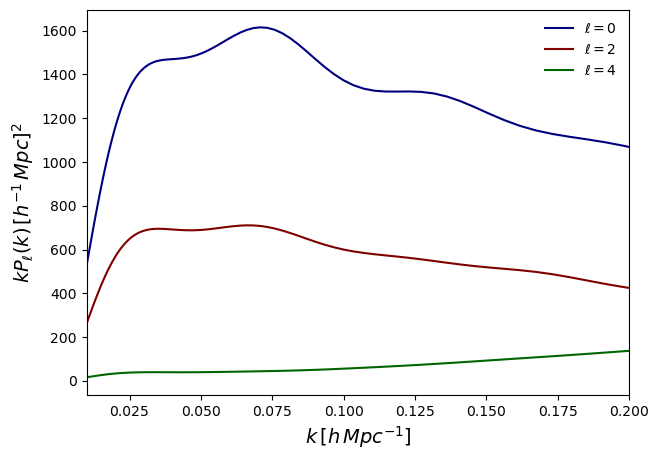

In [24]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(k, k * P0, color = 'navy', ls='-', label=r'$\ell = 0$')
axs.plot(k, k * P2, color = 'maroon', ls='-', label=r'$\ell = 2$')
axs.plot(k, k * P4, color = 'darkgreen', ls='-', label=r'$\ell = 4$')

axs.set_xlim([k[0], 0.2])
#axs.set_ylim([-200.0, 1800])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

In [25]:
np.array([P0, P2, P4])

array([[52897.06241336, 53603.32639464, 54280.38836044, 54925.60839721,
        55535.87241226, 56107.88944401, 56638.4488408 , 57124.53534662,
        57563.40598826, 57952.17801871, 58287.59971293, 58565.76208549,
        58783.2107142 , 58937.20098115, 59024.82263001, 59043.34792037,
        58990.22935949, 58862.28098337, 58657.0346672 , 58373.28983407,
        58009.50135812, 57564.26577747, 57036.70640012, 56426.73636415,
        55735.32387356, 54964.56604652, 54116.59294286, 53193.69738107,
        52198.47759697, 51134.85508652, 50008.85375509, 48829.12122917,
        47603.91485467, 46341.25316018, 45049.15180269, 43734.86261286,
        42406.65702795, 41076.61922295, 39756.87860061, 38458.89725713,
        37192.97373757, 35967.36666219, 34788.63475813, 33662.85115101,
        32595.25051296, 31590.25480728, 30651.79135793, 29779.44308581,
        28968.21587226, 28212.85270721, 27505.63360473, 26835.60462939,
        26189.75272064, 25553.38338755, 24910.67734321, 24246.29